# 训练VAE网络
首先要运行make.ipynb，得到gen_example文件夹

In [1]:
import torch
from vae import VAEt, loss_function, myDataset
from torch.utils.data import DataLoader
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt

# from checkpoint import save_checkpoint
import sys
sys.path.append('../../')
from utils.checkpoint import save_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
dataset = myDataset("gen_example")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print(dataset[0].shape)
model = VAEt(84).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
checkpoint_path = "vae.pth"
min_loss = float('inf')
losses = []
epoch_now = 0

torch.Size([660, 84])


## 加载以往数据
规定每次保存必须按以下格式：
```python
save_checkpoint({
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'avg_loss': avg_loss,
    'min_loaa': min_loss,
    'optimizer' : optimizer.state_dict(),
}, is_best)
```

In [3]:
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    min_loss = checkpoint['min_loss']
    avg_loss = checkpoint['avg_loss']
    losses.append(avg_loss)
    epoch_now = checkpoint['epoch']
    print(f"Checkpoint loaded from '{checkpoint_path}'\nepoch: {epoch_now}, loss: {avg_loss}, min_loss: {min_loss}")
else:
    print("Checkpoint file does not exist. Training from scratch.")

Checkpoint file does not exist. Training from scratch.


In [ ]:
# 重置min
min_loss = float('inf')

In [ ]:
# 重置优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
epoch_total = 500
gen_interval = 30    # generate samples every 50 epochs
stage_save_interval = 30    # save checkpoint every 50 epochs

gen_folder = 'gen_sample'
if not os.path.exists(gen_folder):
    os.makedirs(gen_folder)

for epoch in range(epoch_now + 1, epoch_total):
    model.train()
    train_loss = 0
    for data in tqdm.tqdm(dataloader, desc=f"Epoch {epoch}/{epoch_total}"):
        data = data.float().to(device)
        optimizer.zero_grad()
        n, o, mu, logvar = model(data)
        loss = loss_function(data, n, o, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(dataloader.dataset)
    losses.append(train_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'min_loss': min_loss,
        'avg_loss': train_loss,
        'optimizer': optimizer.state_dict(),
    }, train_loss < min_loss, filename = checkpoint_filename)

    if train_loss < min_loss:
        min_loss = train_loss

    print(f"====> Epoch: {epoch} Average loss: {train_loss:.4f}")

    if epoch % gen_interval == 0:
        model.eval()
        with torch.no_grad():
            n, o = model.generate(660, device, 1)
            n = n.squeeze().cpu().numpy().T
            o = o.squeeze().cpu().numpy().T
            fig, axs = plt.subplots(2, 1, figsize=(12, 10))
            im1 = axs[0].imshow(n, cmap='gray', aspect='auto')
            axs[0].set_title('Generated Sample Note')
            axs[0].set_xlabel('seqlen')
            axs[0].set_ylabel('features')
            fig.colorbar(im1, ax=axs[0])
            
            im2 = axs[1].imshow(o, cmap='gray', aspect='auto')
            axs[1].set_title('Generated Sample Onset')
            axs[1].set_xlabel('seqlen')
            axs[1].set_ylabel('features')
            fig.colorbar(im2, ax=axs[1])
            plt.savefig(f"{gen_folder}/epoch{epoch}.png")
            plt.close()
    epoch_now = epoch


In [ ]:
train_loss_title = f'Loss of VAE from {epoch_now} to {epoch_total} epoch'
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(train_loss_title)
plt.savefig(f'{train_loss_title}.jpg')

In [ ]:
best_checkpoint_path = "model_best.pth"
if os.path.isfile(best_checkpoint_path):
    checkpoint = torch.load(best_checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    min_loss = checkpoint['min_loss']
    avg_loss = checkpoint['avg_loss']
    losses.append(avg_loss)
    epoch_now = checkpoint['epoch']
    print(f"Checkpoint loaded from '{best_checkpoint_path}'\nepoch: {epoch_now}, loss: {avg_loss}, min_loss: {min_loss}")

Checkpoint loaded from 'model_best.pth'
epoch: 143, loss: 1225.7535321646274, min_loss: 1227.497845077411


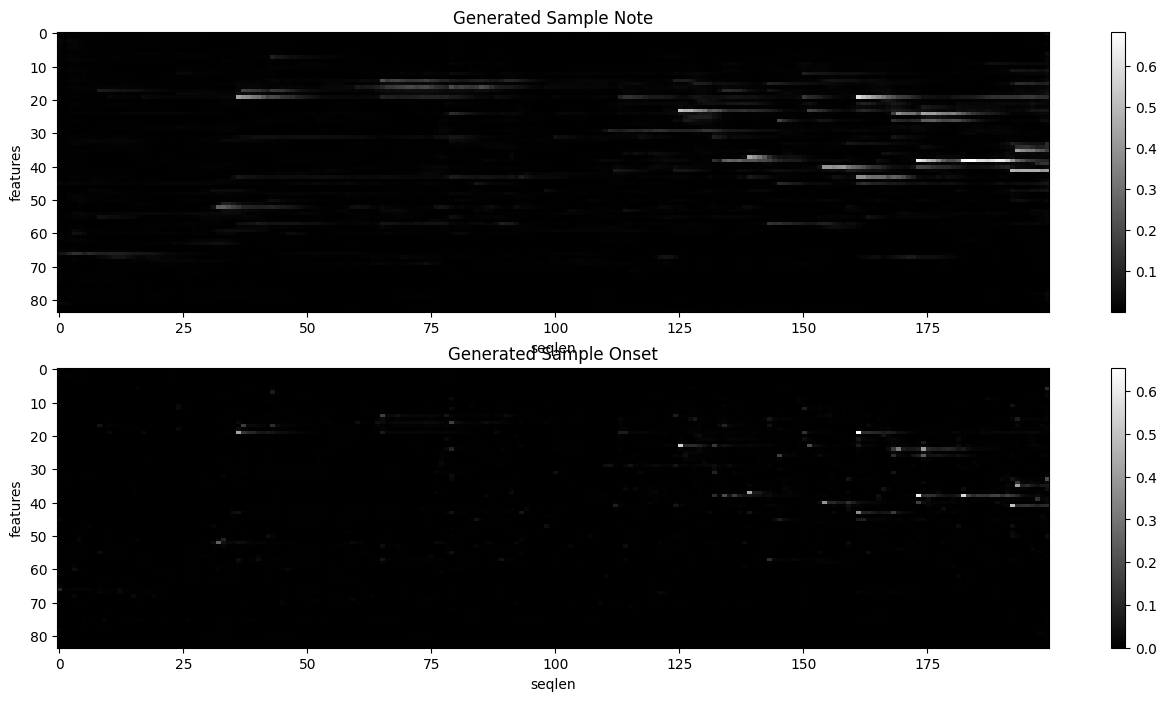

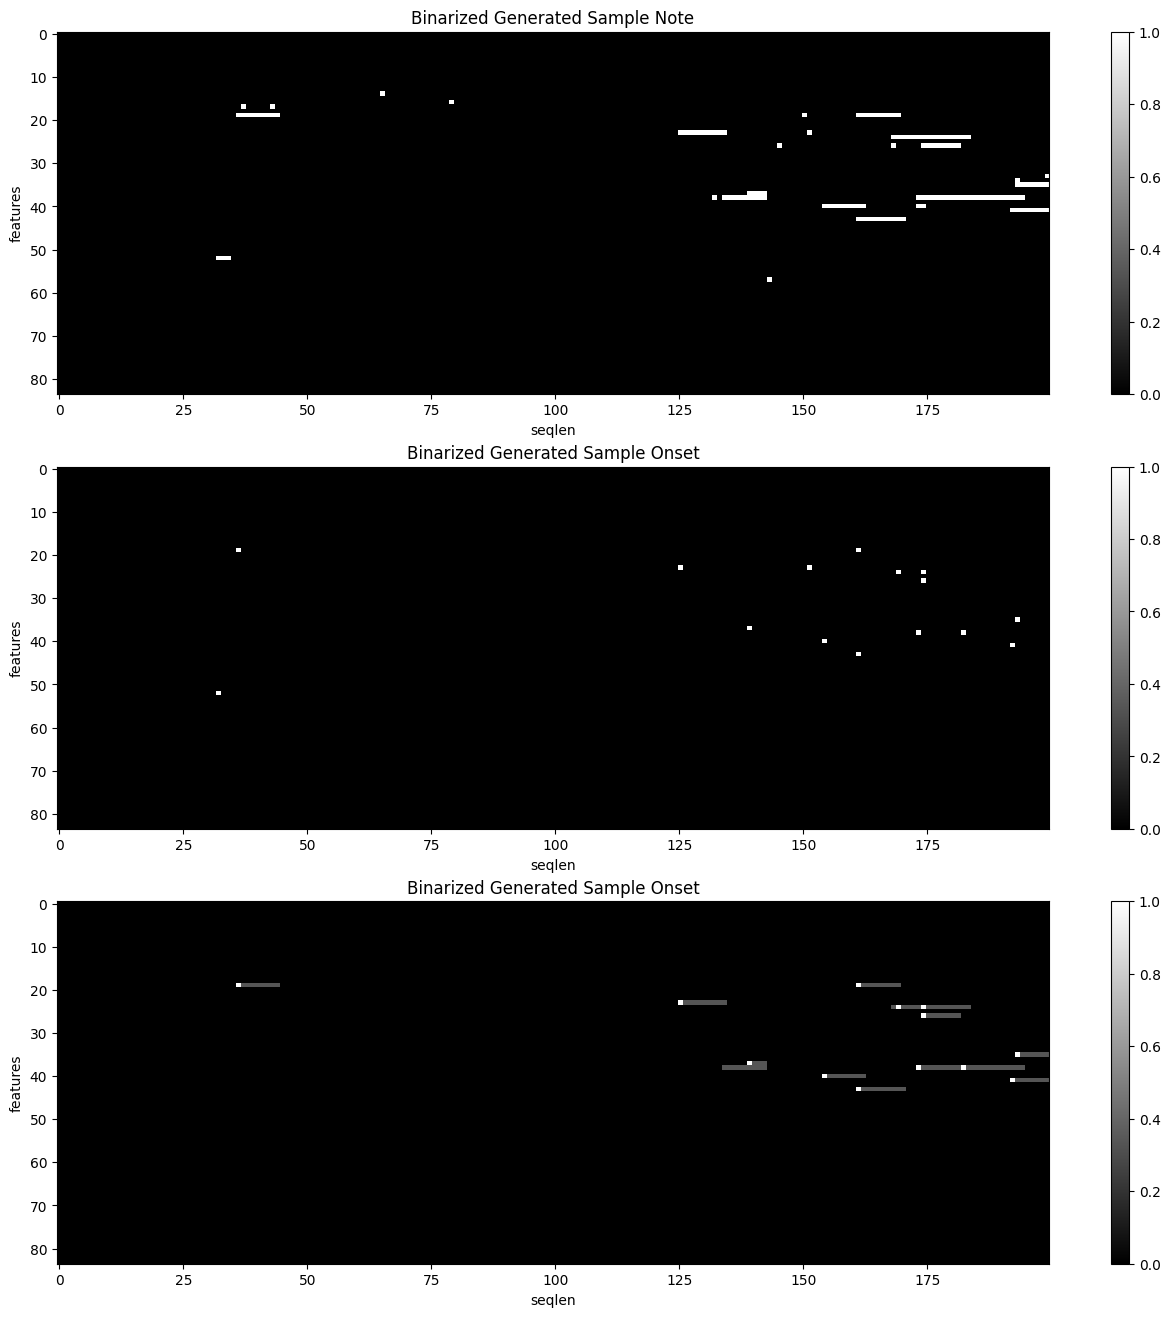

In [ ]:
from utils.postprocess import *

model.eval()
with torch.no_grad():
    n, o = model.generate(200, device, 1)
    n = n.squeeze().cpu().numpy().T
    o = o.squeeze().cpu().numpy().T
    fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    im1 = axs[0].imshow(n, cmap='gray', aspect='auto')
    axs[0].set_title('Generated Sample Note')
    axs[0].set_xlabel('seqlen')
    axs[0].set_ylabel('features')
    fig.colorbar(im1, ax=axs[0])
    
    im2 = axs[1].imshow(o, cmap='gray', aspect='auto')
    axs[1].set_title('Generated Sample Onset')
    axs[1].set_xlabel('seqlen')
    axs[1].set_ylabel('features')
    fig.colorbar(im2, ax=axs[1])

    n = n + o
    n_threshold = OTSU_threshold(n)
    o_threshold = OTSU_threshold(o)
    n_binary = schmitt_binarization(n, n_threshold/1.2, n_threshold)
    o_binary = (o > o_threshold).astype(np.uint8)
    # min_len(n_binary, 4)
    max_len_(o_binary, 1, 4)

    fig, axs = plt.subplots(3, 1, figsize=(16, 16))
    im1 = axs[0].imshow(n_binary, cmap='gray', aspect='auto')
    axs[0].set_title('Binarized Generated Sample Note')
    axs[0].set_xlabel('seqlen')
    axs[0].set_ylabel('features')
    fig.colorbar(im1, ax=axs[0])
    
    im2 = axs[1].imshow(o_binary, cmap='gray', aspect='auto')
    axs[1].set_title('Binarized Generated Sample Onset')
    axs[1].set_xlabel('seqlen')
    axs[1].set_ylabel('features')
    fig.colorbar(im2, ax=axs[1])
    
    note = o_binary*2 + n_binary
    min_len_(note, 4)
    im3 = axs[2].imshow(note, cmap='gray', aspect='auto')
    axs[2].set_title('Binarized Generated Sample Onset')
    axs[2].set_xlabel('seqlen')
    axs[2].set_ylabel('features')
    fig.colorbar(im2, ax=axs[2])

    plt.show()